In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV

GOAL_POSITIVE_SAMPLE_PERCENTAGE = 0.35

PATH_TO_TRAIN_IMAGES = os.path.join(os.pardir, 'ISIC2018_Task3_Training_Input')
PATH_TO_TEST_IMAGES = os.path.join(os.pardir, 'ISIC2018_Task3_Test_Input')

PATH_TO_TRAIN_GROUND_TRUTH = os.path.join(os.pardir, 'ISIC2018_Task3_Training_GroundTruth.csv')
PATH_TO_TEST_GROUND_TRUTH = os.path.join(os.pardir, 'ISIC2018_Task3_Test_GroundTruth.csv')

OUTPUT_HEIGHT = 150
OUTPUT_WIDTH = 200

N_COMPS = 30

RANDOM_STATE = 42


def get_flat_data(ground_truth, path_to_images, filename):
    image_names = ground_truth['image'].values
    num_images = len(image_names)

    flat_data = np.empty((num_images, OUTPUT_HEIGHT * OUTPUT_WIDTH * 3), dtype=np.float16)

    for i, image_file in enumerate(image_names):
        with Image.open(os.path.join(path_to_images, image_file + '.jpg')) as img:
            img_resized = img.resize((OUTPUT_WIDTH, OUTPUT_HEIGHT), Image.LANCZOS)
            img_norm = np.array(img_resized) / 255
            img_flatten = img_norm.flatten()
            flat_data[i] = img_flatten

        print(f'Images processed: {i+1}/{num_images}', end='\r')

    np.save(filename, flat_data)
    return flat_data


def reduce_dataset(dataset, filename, pca=None):
    if not pca:
        pca = PCA(n_components=N_COMPS)
        pca.fit(dataset)

    dataset_reduced = pca.transform(dataset)

    np.save(filename, dataset_reduced)
    with open('pca.pkl', 'wb') as file:
        pickle.dump(pca, file)

    return (dataset_reduced, pca)


def downsample_dataset(X, y):
    positive_samples_current = y.sum()
    all_samples_goal = int(positive_samples_current // GOAL_POSITIVE_SAMPLE_PERCENTAGE)
    all_samples_current = X.shape[0]
    samples_to_delete_number = all_samples_current - all_samples_goal
    negative_samples_indices = np.where(y!= 1)[0]

    np.random.seed(RANDOM_STATE)
    delete_indices = np.random.choice(negative_samples_indices, size=samples_to_delete_number, replace=False)

    X_downsampled = np.delete(X, delete_indices, axis=0)
    y_downsampled = np.delete(y, delete_indices, axis=0)

    np.save('X_train.npy', X_downsampled)
    np.save('y_train.npy', y_downsampled)

    return (X_downsampled, y_downsampled)

In [3]:
train_ground_truth = pd.read_csv(PATH_TO_TRAIN_GROUND_TRUTH)
X_train = get_flat_data(train_ground_truth, PATH_TO_TRAIN_IMAGES, 'X_train.npy')
y_train = train_ground_truth['MEL'].values

X_train, y_train = downsample_dataset(X_train, y_train)

X_train, pca = reduce_dataset(X_train, 'X_train_reduced.npy')

In [4]:
test_ground_truth = pd.read_csv(PATH_TO_TEST_GROUND_TRUTH)
X_test = get_flat_data(test_ground_truth, PATH_TO_TEST_IMAGES, 'X_test.npy')
X_test, _ = reduce_dataset(X_test, 'X_test_reduced.npy', pca)
y_test = test_ground_truth['MEL'].values

In [5]:
param_grid = {'n_estimators': [100, 200, 300, 400]}
model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc')
model.fit(X_train, y_train)
print('Best params:', model.best_params_)

Best params: {'n_estimators': 300}


In [8]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)

Accuracy: 0.77


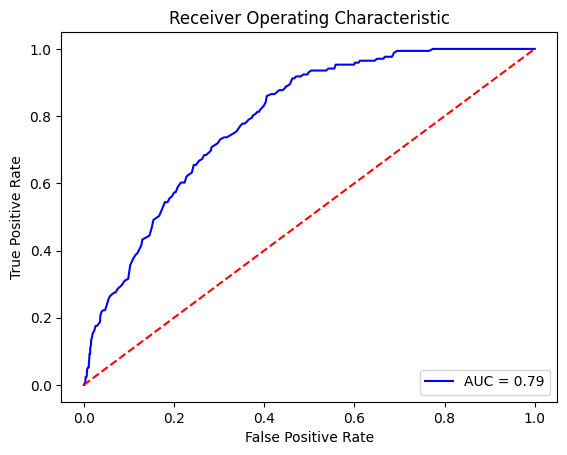

In [6]:
from sklearn.metrics import accuracy_score


def plot_curve(x, y, auc, ax):
    ax.plot(x, y, 'b', label = 'AUC = %0.2f' % auc)
    ax.legend(loc = 'lower right')


def plot_roc_curve(probabilities, y_true, ax):
    fpr, tpr, _ = roc_curve(y_true, probabilities)
    roc_auc = auc(fpr, tpr)
    plot_curve(fpr, tpr, roc_auc, ax)
    ax.set_title('Receiver Operating Characteristic')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.plot([0, 1], [0, 1],'r--')


probabilities = model.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots()
plot_roc_curve(probabilities, y_test, ax)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
